In [1]:
import os
import sys
from tqdm.notebook import tqdm
import numpy as np
import csv
import pickle

sys.path.append('/usr/local/Cellar/graph-tool/2.31_1/lib/python3.8/site-packages/')
import graph_tool.all as gt

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from matplotlib.animation import FuncAnimation
%matplotlib inline

/usr/local/Cellar/graph-tool/2.31_1/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.31_1/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.31_1/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/local/Cellar/graph-tool/2.31_1/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [2]:
DUMP_LANG = 'en'
DUMP_DATE = '20200401'
RESULTS_DIR = 'results/'
page_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-pages.csv"
edge_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-links-edgelist.csv"
adj_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-links-adjlist.csv"
graph_file = RESULTS_DIR + f"{DUMP_LANG}wiki-{DUMP_DATE}-graph.gt"

In [3]:
load_from_file = True

if load_from_file:
    graph = gt.load_graph(graph_file)
    id_index_map = np.zeros((np.max(graph.vp.id.a)+1,), 'int')
    id_index_map[graph.vp.id.a] = graph.get_vertices()
    
else:
    graph = gt.Graph(directed=True)
    with open(edge_file) as f:
        graph.vp.id = graph.add_edge_list((tuple(map(int,l.split(' '))) for l in tqdm(f)), hashed=True).copy(value_type='int')
    
    id_index_map = np.zeros((np.max(graph.vp.id.a)+1,), 'int')
    id_index_map[graph.vp.id.a] = graph.get_vertices()
    graph.vp.title = graph.new_vp('string')
    with open(page_file, newline='') as f:
        for row in tqdm(csv.reader(f)):
            graph.vp.title[id_index_map[int(row[0])]] = row[1]
            
    graph.save(graph_file)
    

In [4]:
title_index_map = {}
for v in tqdm(graph.vertices()): title_index_map[graph.vp.title[v]] = v

In [24]:
largest_component_filter = gt.label_largest_component(graph)
lc_graph = gt.GraphView(graph, largest_component_filter)


In [25]:
lc_graph.num_vertices()

5408021

## Analysis

In [7]:
plt.style.use('fivethirtyeight')

### Furthest away pages

In [8]:
source = 'United States'

dist, pred = gt.shortest_distance(lc_graph, title_index_map[source], pred_map=True)
for v in np.argsort(dist.a)[::-1]:
    if dist[v] < 10: break
    print(dist[v], lc_graph.vp.title[v])

67 1930 São Paulo FC season
66 1931 São Paulo FC season
65 1932 São Paulo FC season
64 1933 São Paulo FC season
63 1934 São Paulo FC season
62 1935 São Paulo FC season
61 1936 São Paulo FC season
60 1937 São Paulo FC season
59 1938 São Paulo FC season
58 1939 São Paulo FC season
57 1940 São Paulo FC season
56 1941 São Paulo FC season
55 1942 São Paulo FC season
54 1943 São Paulo FC season
53 1944 São Paulo FC season
52 1945 São Paulo FC season
51 1946 São Paulo FC season
50 1947 São Paulo FC season
49 1948 São Paulo FC season
48 1949 São Paulo FC season
47 1950 São Paulo FC season
46 1951 São Paulo FC season
45 1952 São Paulo FC season
44 1953 São Paulo FC season
44 1968 Liga Deportiva Universitaria de Quito season
43 1969 Liga Deportiva Universitaria de Quito season
43 1954 São Paulo FC season
42 1955 São Paulo FC season
42 Papyrus Oxyrhynchus 158
42 1970 Liga Deportiva Universitaria de Quito season
41 Papyrus Oxyrhynchus 157
41 1956 São Paulo FC season
41 1971 Liga Deportiva Universi

11 Anochanus sinensis
11 Emerging Island
11 Florencio Morán
11 Hazem Daouk
11 1780 in Sweden
11 1986 São Paulo FC season
11 1967 Soviet Class B
11 Sebastian Amigorena
11 1898 Cork Senior Football Championship
11 1943 Cork Senior Football Championship
11 Bill Tulip
11 1996 Campeonato Gaúcho
11 Storylines of Shortland Street (2005)
11 Wichard
11 Results breakdown of the 1995 Spanish local elections (Valencian Community)
11 Ernie Collett
11 Agogo
11 1909 Cork Senior Football Championship
11 List of Adult Contemporary top 10 singles in 1970 (U.S.)
11 10 years
11 Rozłazino railway station
11 Lamman
11 Norma Andrews
11 Meade Hill (Schoharie County, New York)
11 First League
11 Seconds Late for the Brighton Line
11 John Weir (footballer)
11 Charles Breyer (soldier)
11 1966–67 Spartan League
11 Berwig Halt railway station
11 Mutual reception
11 2013 French Indoor Athletics Championships
11 1942–43 Heart of Midlothian F.C. season
11 2012 Indonesia national football team results
11 Anametalia st

### Histogram of distances

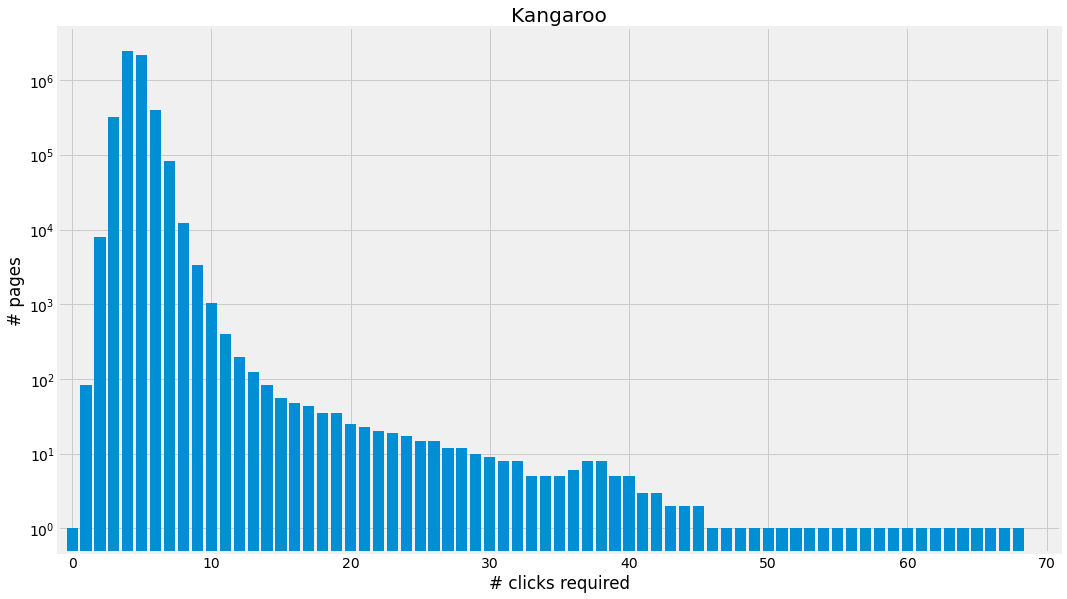

In [14]:
source = 'Kangaroo'

fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('white')

dist = gt.shortest_distance(lc_graph, title_index_map[source]).a[lc_graph.get_vertices()]
u, ucount = np.unique(dist,return_counts=True)

ax.bar(u, ucount)
ax.set_title(source)
ax.set_xlim(-1,71)
ax.set_xlabel('# clicks required')
ax.set_yscale('log')
ax.set_ylabel('# pages')
ax.label_outer()

plt.show()


### Shortest path

In [119]:
source = 'Atmosphere'
target = 'Island'
for path in gt.all_shortest_paths(lc_graph, title_index_map[source], title_index_map[target]):
    print([lc_graph.vp.title[v] for v in path])

['Atmosphere', 'Mars', 'Prime meridian', 'São Miguel Island', 'Island']
['Atmosphere', 'Mars', 'Volcanic crater lake', 'São Miguel Island', 'Island']
['Atmosphere', 'Mars', 'Prime meridian', 'Santa Maria Island', 'Island']
['Atmosphere', 'Ancient Greek', 'Mediterranean Sea', 'Coast', 'Island']
['Atmosphere', 'Mars', 'Volcanic crater lake', 'Flores Island (Azores)', 'Island']
['Atmosphere', 'Mars', 'Volcanic crater lake', 'Pico Island', 'Island']
['Atmosphere', 'Aeolian processes', 'The Bahamas', 'Clarence Town', 'Island']
['Atmosphere', 'Aeolian processes', 'The Bahamas', 'Clarence Town', 'Island']
['Atmosphere', 'Atmosphere of Earth', 'Biosphere', 'Biome', 'Island']
['Atmosphere', 'Atmosphere of Earth', 'Biosphere', 'Biome', 'Island']
['Atmosphere', 'Wind', 'Montane ecosystems', 'Biome', 'Island']
['Atmosphere', 'Aeolian processes', 'Europe', 'Biome', 'Island']
['Atmosphere', 'Aeolian processes', 'Europe', 'Biome', 'Island']
['Atmosphere', 'Earth', 'Human impact on the environment', '

### Betweenness centrality

### Histogram of vertex degrees

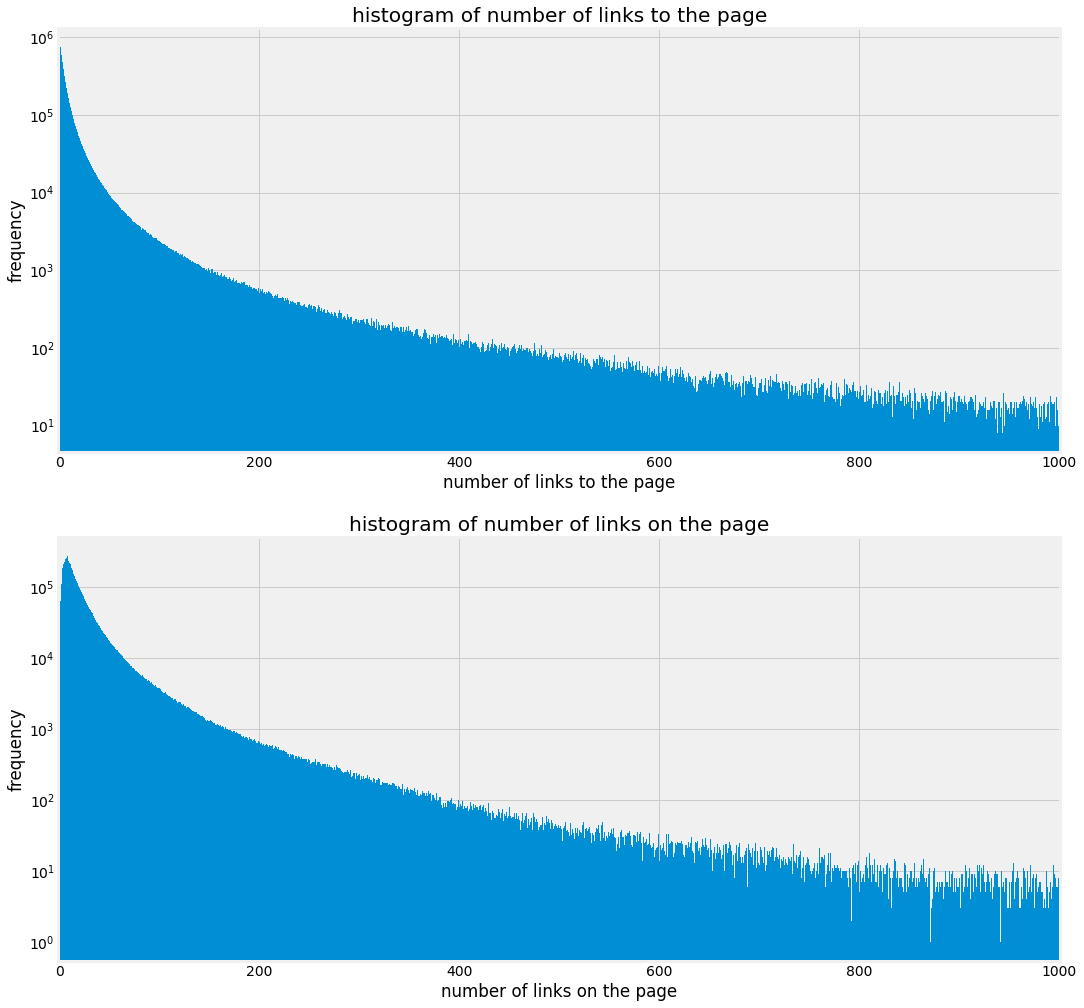

In [13]:
fig, axs = plt.subplots(2,figsize=(16,16))
fig.patch.set_facecolor('white')

lim = 1000

hist_type = ['number of links to the page','number of links on the page']

for (i,d) in enumerate(['in','out']):
    hist = gt.vertex_hist(lc_graph, d)[0]
    
    ax = axs.flat[i]
    ax.bar(np.arange(lim), hist[:lim])
    ax.set_title('histogram of ' + hist_type[i])
    ax.set_xlim(-1,lim+1)
    ax.set_xlabel(hist_type[i])
    ax.set_yscale('log')
    ax.set_ylabel('frequency')
#     ax.label_outer()

plt.show()


### Comparison of connectivity w/ and w/o countries

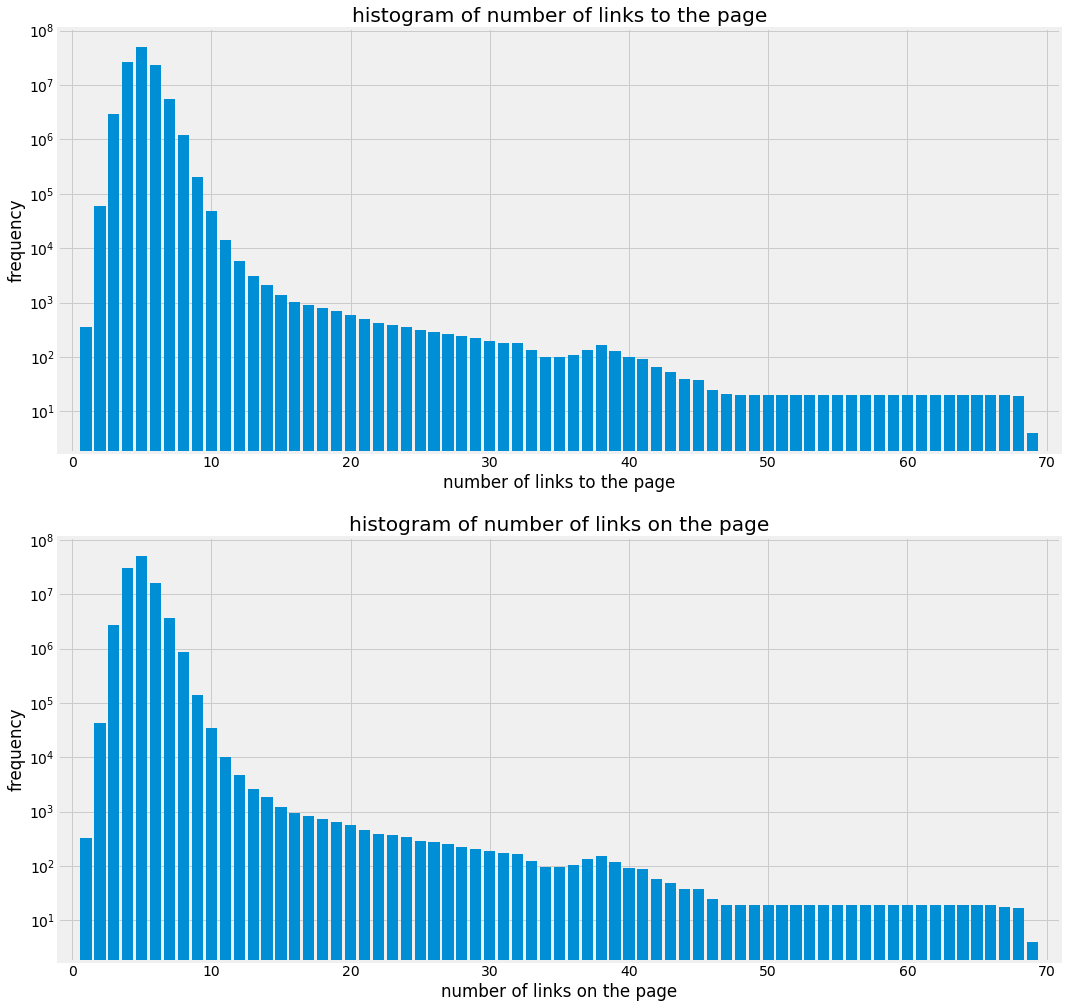

In [15]:
fig, axs = plt.subplots(2,figsize=(16,16))
fig.patch.set_facecolor('white')

hist_type = ['number of links to the page','number of links on the page']

cfilter = lc_graph.new_vp('bool',val=True)
with open('resources/country-codes.pkl', 'rb') as f:
    d = pickle.load(f)
    for i in d:
        if d[i] in title_index_map: cfilter[title_index_map[d[i]]] = False

for i in range(2):
    lc_graph.set_vertex_filter([None,cfilter][i])
    hist = gt.distance_histogram(graph, samples=20)[0]
    lc_graph.clear_filters()
    
    ax = axs.flat[i]
    ax.bar(np.arange(hist.size), hist)
    ax.set_title('histogram of ' + hist_type[i])
    ax.set_xlabel(hist_type[i])
    ax.set_xlim(-1,71)
    ax.set_yscale('log')
    ax.set_ylabel('frequency')
#     ax.label_outer()

plt.show()


### Analyse the most connected 1/2 of the graph

In [28]:
vb_map.a

PropertyArray([0.00000000e+00, 1.69534236e-08, 2.54158584e-08, ...,
               0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [29]:
vb_map = gt.betweenness(lc_graph, np.random.choice(lc_graph.get_vertices(), 250, replace=False))[0]
vb_map.a[np.setdiff1d(graph.get_vertices(), lc_graph.get_vertices(), assume_unique=True)] = -1

In [30]:
for v in np.argsort(vb_map.a)[::-1][:30]: print(v, vb_map[v], lc_graph.vp.title[v])

471 0.042140787296585665 United States
657 0.022842921273460756 New York City
508 0.020052828041453113 United Kingdom
496 0.016839501270094218 France
566 0.015685162907754197 Catholic Church
1727 0.01296093448458734 India
498 0.012698404196746045 Italy
6820 0.012191559899127296 Lepidoptera
502 0.0121487288947961 World War II
461 0.011853663071038648 Germany
999 0.011202845987041441 London
862 0.010339408783547329 Netherlands
524 0.009875238908317475 Australia
981 0.009850552021044585 England
4882 0.009770365039368317 Köppen climate classification
614 0.009016517847636301 California
1250 0.008291829901557581 World War I
5056 0.008005630516135096 Poland
525 0.007550669318461767 Japan
636 0.0074919688964429874 Mexico
1683 0.007283196100825957 Ireland
8496 0.007181529483642139 List of sovereign states
1522 0.007174333930683364 Chicago
1380 0.007132355907593136 Canada
1276 0.007095379270471747 Spain
95508 0.006601575178989198 University of Florida
2351 0.006573915928313912 Wales
511 0.00644

In [18]:
def distance_distribution(g, ind, starts, ends):
    u, ucount = np.unique(np.concatenate([gt.shortest_distance(g,v).a[ends] for v in starts]), return_counts=True)
    o = np.zeros(ind.size)
    o[u[u < 200]] = ucount[u < 200]
    return o / np.sum(ucount)

vertex_order = np.argsort(vb_map.a)[::-1]
ind = np.arange(200)

distributions = {}

test_vertices = vertex_order[int(lc_graph.num_vertices()/2):lc_graph.num_vertices()]

sample_starts = np.random.choice(test_vertices, 50, replace=False)

In [ ]:
vertex_order

In [19]:
percentage_excluded = list(np.concatenate([
    np.arange(0,.01,.001),
    np.arange(.01,.1,.01),
    np.arange(.1,1,.1),
    np.arange(1,10,1.0),
    np.arange(10,41,5.0)
]))

for p in tqdm(percentage_excluded):
    if p in distributions: continue
    f = lc_graph.new_vp('bool',False)
    f.a[vertex_order[int(round(lc_graph.num_vertices()*p/100)):]] = True
    g = gt.GraphView(lc_graph,f)
    distributions[p] = distance_distribution(g, ind, sample_starts, test_vertices)

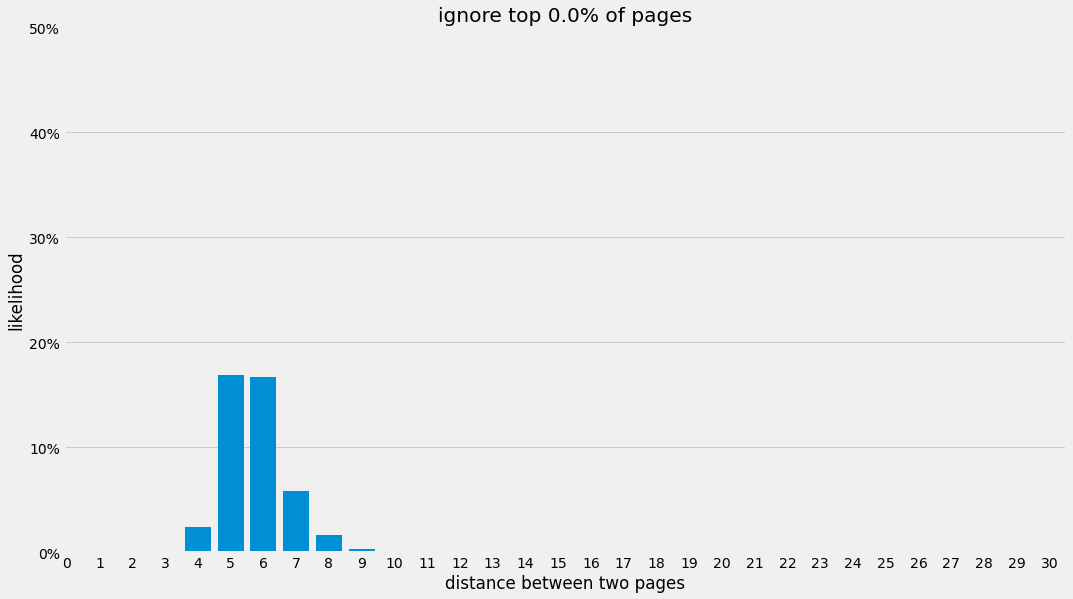

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
bars = ax.bar(ind, np.zeros(ind.size))

ax.set_xlabel('distance between two pages')
ax.set_ylabel('likelihood')
ax.set_xticks(ind)
ax.set_xlim(-.1,30.5)
ax.set_ylim(0,.5)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.grid(False,axis='x')

def update(i):
    for j,b in enumerate(bars):
        b.set_height(distributions[percentage_excluded[i]][j])
    ax.set_title(f"ignore top {percentage_excluded[i]:.3}% of pages")

ani = FuncAnimation(fig, update, frames=range(len(percentage_excluded)), interval=250, repeat_delay=3000)

ani.save('removing_central_pages.mp4')

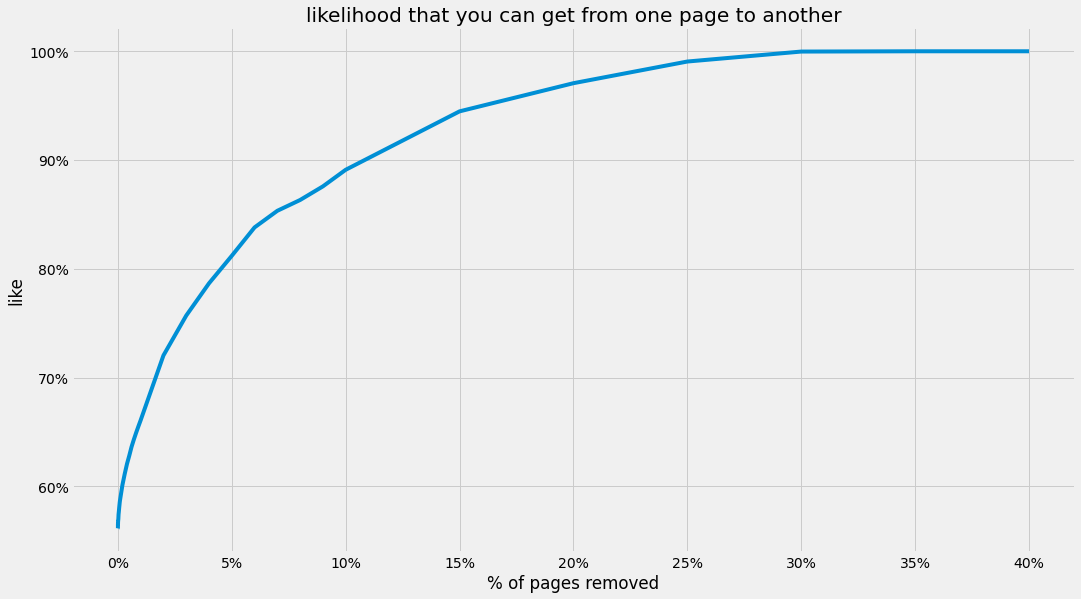

In [21]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(percentage_excluded,[1-np.sum(distributions[p]) for p in percentage_excluded])
ax.set_title('likelihood that you can get from one page to another')
ax.set_xlabel('% of pages removed')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x/100)))

ax.set_ylabel('like')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.show()

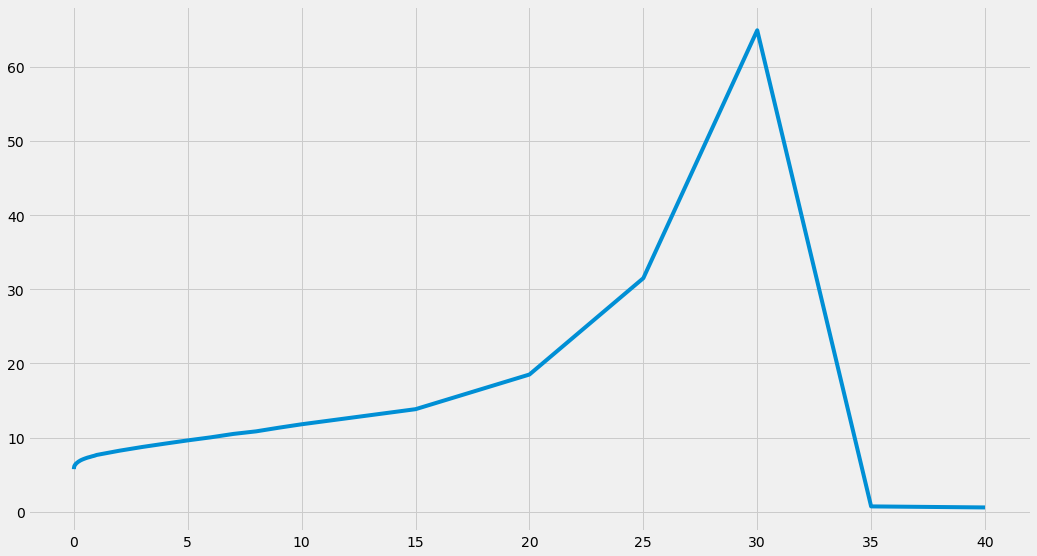

In [22]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(percentage_excluded, [np.dot(distributions[p],ind)/np.sum(distributions[p]) for p in percentage_excluded])

plt.show()

In [77]:
d = {}
s = {}
for i,p in enumerate(percentage_excluded):
    d[p] = distributions[i]
    s[p] = subgraphs[i]
distributions = d
subgraphs = s

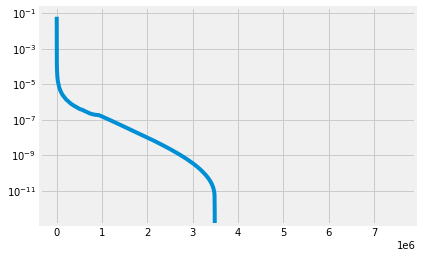

In [201]:
fig,ax = plt.subplots()
ax.plot(np.sort(vb)[::-1])
ax.set_yscale('log')
plt.show()


In [112]:
di, p = gt.pseudo_diameter(small_graph)

In [114]:
tuple(map(lambda v: graph.vp.title[v], p))

('Serif', 'Transgender pornography')

In [119]:
np.sort(vb)[::-1][lc_graph.num_vertices()//100]

6.75379168520426e-06

In [293]:
f = lc_graph.new_vp('bool',val=False)
f.a[np.argsort(vb)[::-1][:100]] = True
g = gt.GraphView(lc_graph,f)

gt.graph_draw(g)

In [297]:
np.sum(np.unique(f.a))

PropertyArray(1, dtype=uint64)

In [298]:
np.unique(f.a)

PropertyArray([0, 1], dtype=uint8)